예제 8.4 스타일 전이

In [ ]:
# 예제 8.4 스타일 전이

# 셋업
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 콘텐츠 이미지/스타일 이미지 크기 확인
content_path = '/content/drive/MyDrive/Datasets/풍차.JPG'  # 파일 경로 지정
content_img = Image.open(content_path)                    # 이미지 가져오기

style_path = tf.keras.utils.get_file(       # Wikimedia Commons에서 다운로드
    'Composition7.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/6/69'
    '/Wassily_Kandinsky_Composition_VII.jpg')
style_img = Image.open(style_path)

print(f"size of content image: {content_img.size}")   # 콘텐츠 이미지 크기 확인
print(f"size of style image: {style_img.size}")       # 스타일 이미지 크기 확인

size of content image: (1920, 1080)
size of style image: (1800, 1218)


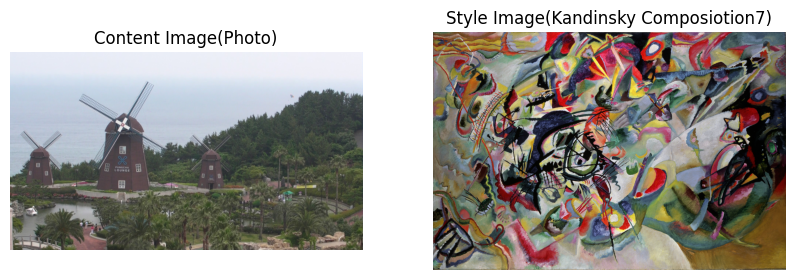

In [ ]:
# 콘텐츠 이미지/스타일 이미지 시각화
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(content_img)
plt.title('Content Image(Photo)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(style_img)
plt.title('Style Image(Kandinsky Composiotion7)')
plt.axis('off')

plt.show()

In [ ]:
# 콘텐츠 이미지/스타일 이미지/스타일 전이 이미지 준비
width, height = content_img.size
img_height = 160
img_width = int(width * img_height / height)   # 이미지의 가로x세로 비율 유지

# 콘텐츠 이미지
content_image = tf.keras.utils.load_img(
    content_path, target_size=(img_height, img_width))  # 이미지 크기 조정
content_image = tf.keras.utils.img_to_array(content_image)   # 배열로 변환
content_image = np.expand_dims(content_image, axis=0)     # 배치 차원 추가
content_image = preprocess_input(content_image)             # VGG19 전처리
content_image = tf.convert_to_tensor(content_image)          # 텐서로 변환

# 스타일 이미지
style_image = tf.keras.utils.load_img(
    style_path, target_size=(img_height, img_width))
style_image = tf.keras.utils.img_to_array(style_image)
style_image = np.expand_dims(style_image, axis=0)
style_image = preprocess_input(style_image)
style_image = tf.convert_to_tensor(style_image)

# 스타일 전이 이미지(랜덤 잡음 이미지)
stylized_image = tf.Variable(content_image)   # 콘텐츠 이미지와 동일한 크기

In [ ]:
# 사전 학습된 VGG19 모델 가져오기
vgg = VGG19(include_top=False,    # 분류기 포함하지 않음
            weights='imagenet')   # ImageNet으로 학습한 가중치
outputs_dict = dict([(layer.name, layer.output) for layer in vgg.layers])

# 활성화 값을 추출하는 모델 생성
model = Model(inputs=vgg.inputs, outputs=outputs_dict,
              name='style_transfer_model')

# 콘텐츠 손실/스타일 손실에 사용되는 계층 지정
content_layer = 'block5_conv2'
style_layer = ['block1_conv1', 'block2_conv1', 'block3_conv1',
               'block4_conv1', 'block5_conv1']

In [ ]:
# 그람 행렬 함수 정의
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))       # (채널, 높이, 너비) 형태로 변환
    feature = tf.reshape(x, (tf.shape(x)[0], -1))   # 높이x너비 벡터 생성
    return tf.matmul(feature, tf.transpose(feature))          # 내적 계산

In [ ]:
# 전체 손실 함수 정의
def total_loss(stylized_image, content_image, style_image):
    inputs = tf.concat(
        [content_image, style_image, stylized_image], axis=0)
    feature = model(inputs)

    # 콘텐츠 손실
    layer_feature = feature[content_layer]
    content_feature = layer_feature[0, :, :, :]    # 콘텐츠 표현
    stylized_feature = layer_feature[2, :, :, :]   # 콘텐츠 특징

    content_loss = tf.reduce_sum(tf.square(stylized_feature - content_feature))

    # 스타일 손실
    style_loss = tf.zeros(shape=())
    for layer_name in style_layer:
        layer_feature = feature[layer_name]
        style_feature = layer_feature[1, :, :, :]
        stylized_feature = layer_feature[2, :, :, :]

        S = gram_matrix(style_feature)      # 스타일 표현
        G = gram_matrix(stylized_feature)   # 스타일 특징

        st_loss = tf.reduce_sum(
            tf.square(G - S)) / (4 * (3**2) * (img_height * img_width)**2)
        style_loss += st_loss

    style_loss = style_loss / len(style_layer)

    # 전체 손실
    loss = content_weight * content_loss + style_weight * style_loss
    return loss

In [ ]:
# 학습
optimizer = Adam(learning_rate=5)   # 학습률 5

# 학습율을 감소하면서 학습하는 경우
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=5.0, decay_steps=30, decay_rate=0.9)
# optimizer = Adam(learning_rate=lr_schedule)

content_weight =1e-9   # 콘텐츠 손실 가중치
style_weight =1e-6     # 스타일 손실 가중치

step = 100   # 반복 횟수
for i in range(step):
    with tf.GradientTape() as tape:   # 자동 미분 수행
        loss = total_loss(stylized_image, content_image, style_image)

    grads = tape.gradient(loss, stylized_image)            # 그레디언트 계산
    optimizer.apply_gradients([(grads, stylized_image)])   # 최적화

    if i == 0 or (i+1) % 10 == 0:
        print(f"step {i+1}  \t loss: {loss:.2f}")   # 손실 출력

step 1  	 loss: 258097.36
step 10  	 loss: 24006.76
step 20  	 loss: 6539.75
step 30  	 loss: 4104.80
step 40  	 loss: 2955.53
step 50  	 loss: 2251.13
step 60  	 loss: 1828.86
step 70  	 loss: 1558.88
step 80  	 loss: 1372.50
step 90  	 loss: 1234.00
step 100  	 loss: 1126.44


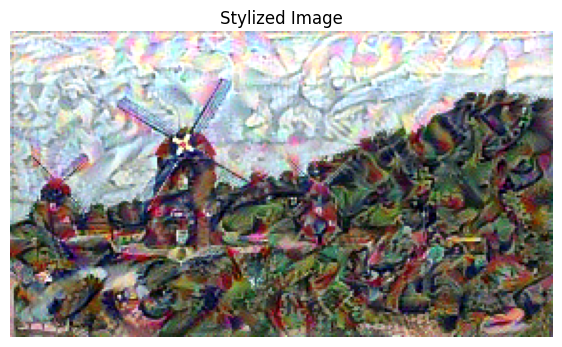

In [ ]:
# 스타일 전이 이미지 시각화
stylized_image = tf.squeeze(stylized_image.numpy(), axis=0)   # 배치 차원 축소
stylized_image = stylized_image[:, :, ::-1]                 # BGR를 RGB로 변환
stylized_image += [124, 117, 104]                   # ImageNet의 평균값 더하기
stylized_image = np.clip(stylized_image, 0, 255).astype("uint8")    # 0 ~ 255

plt.figure(figsize=(7, 7))

plt.imshow(stylized_image)
plt.title('Stylized Image')
plt.axis('off')

plt.show()

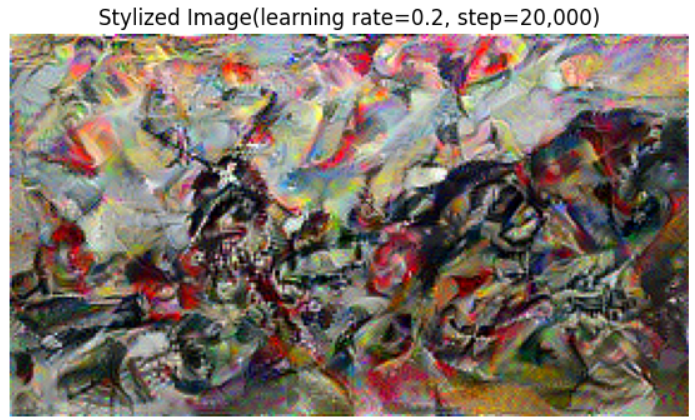

In [ ]:
# 스타일 전이 이미지 저장
tf.keras.utils.save_img('/content/drive/MyDrive/Colab Notebooks/'
   'stylized_image1.png', stylized_image)

In [ ]:
# 저장된 이미지 불러오기
file_path = '/content/drive/MyDrive/Colab Notebooks/stylized_image1.png'
stylized_image = Image.open(file_path)